In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Check if CUDA (GPU support) is available
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [24]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as h5f:
        images = [h5f[img_name]["hist"][:].T[:,0:750] for img_name in h5f.keys()]
        npulses = [h5f[img_name].attrs['npulses'] for img_name in h5f.keys()]
    scaler = MinMaxScaler(feature_range=(-1,1))
    for i in range(len(images)):
        images[i] = scaler.fit_transform(images[i])
    print(images[0].shape)
    return images,npulses,scaler



# Prepare sequences and targets
def create_sequences_and_targets(images,npulses):
    sequences = []
    npulses_targets = []
    for img, puls in zip(images,npulses):
        npulses_targets.append(puls)
        sequences.append(img)
    print(len(sequences))
    print(sequences[0].shape)

    print(len(npulses_targets))
    print(npulses_targets[0].shape)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(npulses_targets, dtype=torch.float32)

# Dataset and DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(ModifiedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_size),  # Existing output
        )
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.dropout(output)
        output = self.fc_layers(output)
        
        # Apply tanh to the existing output
        new_output = torch.relu(output)  # New output without tanh
        return new_output

In [53]:
# Hyperparameters
batch_size = 8
num_epochs = 20
learning_rate = 0.003
input_size = 750
hidden_size = 128
output_size = 1
seq_length = 16  # Number of previous rows to consider


In [26]:
# Load and preprocess data
data_file = '../lstm_data2_simdata.h5'  # Replace with the actual path to your HDF5 file
images,npulses, scaler = load_and_preprocess_data(data_file)

# # Create sequences and targets
sequences, targets = create_sequences_and_targets(images,npulses)


(16, 750)
10000
(16, 750)
10000
()


In [54]:
# # Create DataLoader
dataset = CustomDataset(sequences, targets)
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size) // 1.5)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(len(dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize the model
model = ModifiedLSTMModel(input_size, hidden_size, output_size, num_layers=1, dropout_prob=0)
model.to(device)
# # Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Define the learning rate scheduler
# StepLR will reduce the learning rate by a factor (gamma) every 'step_size' epochs
# step_size = 5  # Adjust this according to your preference
# gamma = 0.5  # Adjust this according to your preference
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

10000


In [55]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

#Initialize variables for early stopping
best_train_loss = 10000
patience = 10  # Number of epochs without improvement to wait before stopping
min_loss_change = 0.001  # Half a percent change threshold
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_sequences, batch_targets in train_dataloader:
#         print(batch_sequences.shape)
#         print(batch_targets.shape)
        batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_sequences)
        
    
        # Calculate loss for the existing outputs (with tanh)
        loss = criterion(outputs, batch_targets)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    loss_change = (best_train_loss-train_loss)/best_train_loss
    # Check if training loss has improved
    print(loss_change)
    if loss_change >= min_loss_change:
        best_train_loss = train_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Check if early stopping criteria are met
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered. Best training loss: {best_train_loss}")
        break
        
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for batch_sequences, batch_targets in val_dataloader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            outputs = model(batch_sequences)
            

            # Calculate loss for the existing outputs (with tanh)
            loss = criterion(outputs, batch_targets)


            total_val_loss += loss.item()
        
        val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    final_num_epochs = epoch
    
#     # Update the learning rate
#     scheduler.step()
    
#     # Print the current learning rate (optional)
#     print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")
print("Training finished!")


0.9999272640352077
Epoch [1/20], Train Loss: 0.7274, Val Loss: 0.7614
0.034874203310287816
Epoch [2/20], Train Loss: 0.7020, Val Loss: 0.6534
0.03168958035355212
Epoch [3/20], Train Loss: 0.6797, Val Loss: 0.6558
0.003979816006662451
Epoch [4/20], Train Loss: 0.6770, Val Loss: 0.6763
-0.0028380182514556886
Epoch [5/20], Train Loss: 0.6790, Val Loss: 0.6729
0.003617592471396567
Epoch [6/20], Train Loss: 0.6746, Val Loss: 0.6528
0.003616497229976143
Epoch [7/20], Train Loss: 0.6722, Val Loss: 0.6758
-0.002788366798754404
Epoch [8/20], Train Loss: 0.6740, Val Loss: 0.6529
-0.0010148563027362742
Epoch [9/20], Train Loss: 0.6728, Val Loss: 0.6537
-0.0014014046112451528
Epoch [10/20], Train Loss: 0.6731, Val Loss: 0.6597
0.00079498619087632
Epoch [11/20], Train Loss: 0.6716, Val Loss: 0.6604
0.006211513249037571
Epoch [12/20], Train Loss: 0.6680, Val Loss: 0.6557


KeyboardInterrupt: 

In [ ]:
train_size

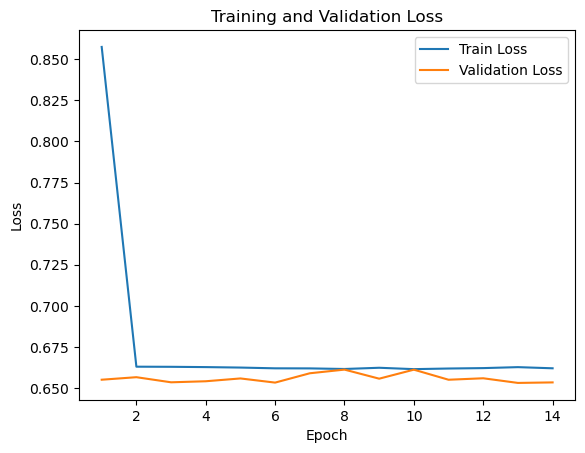

In [32]:
# Plotting training and validation losses
plt.plot(range(1, final_num_epochs + 1), train_losses[0:final_num_epochs], label='Train Loss')
plt.plot(range(1, final_num_epochs + 1), val_losses[0:final_num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'lstm_npulses_model.pth')

In [37]:
# Load the trained model
model = ModifiedLSTMModel(input_size, hidden_size, output_size, num_layers=1, dropout_prob=0)
model.to(device)
model.load_state_dict(torch.load('lstm_npulses_model.pth'))
model.eval()

new_images = images  

new_example_image_normalized= new_images[100]
examples_pulses = npulses[100]

initial_input = torch.tensor(new_example_image_normalized, dtype=torch.float32)
npulses_list = []
with torch.no_grad():
    input_seq = initial_input.to(device)
    predicted = model(input_seq)
    print(predicted.shape)
    predicted = predicted.to('cpu')
        
# Plot the ground truth and predicted images side by side
def plot_image(data):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes[0].imshow(data, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title(f'True' + f'Pulses: {examples_pulses} ;  Predicted Pulses: {predicted}')

    plt.show
    
plot_image(new_example_image_normalized)





IndexError: too many indices for tensor of dimension 2